
# Generating Movie Recommendations

### Unsupervised_Learning_ZM6

1. Wendy Ngcobo
2. Mora Magakwe
3. Sandra Malope
4. Katleho Moketo
5. Morris
6. Matthews


## Introduction

Recommendation systems are becoming increasingly important in today’s extremely busy world. People are forever short on time due to the tasks they need to accomplish in the limited time they have. Therefore, the recommendation systems are very important as they assist in making the right choices.

The purpose of a recommendation system basically is to search for content that would be interesting to an individual. Moreover, it involves a number of factors to create personalised lists of useful and interesting content specific to each user/individual. Recommendation systems are Artificial Intelligence based algorithms that skim through all possible options and create a customized list of items that are interesting and relevant to an individual. These results are based on their profile, search/browsing history, what other people with similar traits/demographics are watching, and how likely are you to watch those movies. This is achieved through predictive modeling and heuristics with the data available.



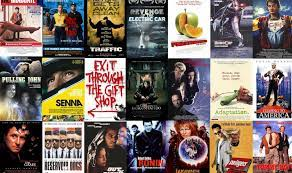

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Installing packages
Please download all relevant packages in. There is no terminal so you will pip install everything.

You can find a list of recommended install from the Intro to Recommender sysytem notebook.

In [2]:
# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Packages for modeling
#from surprise import Reader
#from surprise import Dataset
#from surprise import KNNWithMeans
#from surprise import KNNBasic
#from surprise.model_selection import cross_validate
#from surprise.model_selection import GridSearchCV
#from surprise import SVD
#from surprise import SVDpp
#from surprise import NMF
#from surprise import SlopeOne
#from surprise import CoClustering
import heapq

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

## Reading in data

In [3]:
df_sample_submission = pd.read_csv('sample_submission.csv')
df_movies = pd.read_csv('movies.csv')
df_imdb = pd.read_csv('imdb_data.csv')
df_genome_scores = pd.read_csv('genome_scores.csv')
df_genome_tags = pd.read_csv('genome_tags.csv')
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_tags = pd.read_csv('tags.csv')
df_links = pd.read_csv('links.csv')

In [4]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
df_movies.shape

(62423, 3)

In [7]:
df_train.shape

(10000038, 4)

In [8]:
df_movies.describe()

,movieId
count,62423.000000
mean,122220.387646
std,63264.744844
min,1.000000
25%,82146.500000
50%,138022.000000
75%,173222.000000
max,209171.000000


In [9]:
df_train.describe()

,userId,movieId,rating,timestamp
count,1.000004e+07,1.000004e+07,1.000004e+07,1.000004e+07
mean,8.119909e+04,2.138911e+04,3.533395e+00,1.215677e+09
std,4.679359e+04,3.919578e+04,1.061124e+00,2.268921e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,4.051000e+04,1.197000e+03,3.000000e+00,1.011742e+09
50%,8.091400e+04,2.947000e+03,3.500000e+00,1.199019e+09
75%,1.215790e+05,8.630000e+03,4.000000e+00,1.447242e+09
max,1.625410e+05,2.091710e+05,5.000000e+00,1.574328e+09


In [10]:
dataset = pd.merge(df_train,df_movies,on = 'movieId')

In [11]:
dataset.head()

,userId,movieId,rating,timestamp,title,genres
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller
2,137050,57669,4.0,1425631854,In Bruges (2008),Comedy|Crime|Drama|Thriller
3,120490,57669,4.5,1408228517,In Bruges (2008),Comedy|Crime|Drama|Thriller
4,50616,57669,4.5,1446941640,In Bruges (2008),Comedy|Crime|Drama|Thriller


In [12]:
dataset.shape

(10000038, 6)

In [13]:
dataset.nunique()

userId        162541
movieId        48213
rating            10
timestamp    8795101
title          48151
genres          1558
dtype: int64

In [14]:
dataset.describe()

,userId,movieId,rating,timestamp
count,1.000004e+07,1.000004e+07,1.000004e+07,1.000004e+07
mean,8.119909e+04,2.138911e+04,3.533395e+00,1.215677e+09
std,4.679359e+04,3.919578e+04,1.061124e+00,2.268921e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,4.051000e+04,1.197000e+03,3.000000e+00,1.011742e+09
50%,8.091400e+04,2.947000e+03,3.500000e+00,1.199019e+09
75%,1.215790e+05,8.630000e+03,4.000000e+00,1.447242e+09
max,1.625410e+05,2.091710e+05,5.000000e+00,1.574328e+09


In [5]:
df_sample_submission.head()

,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0
3,1_6711,1.0
4,1_7318,1.0


## EDA
Discovery phase and data understanding

In [15]:
#average rating
a=dataset
a=a.groupby('title')['rating'].mean()
a

title
"BLOW THE NIGHT!" Let's Spend the Night Together (1983)    3.000000
"Great Performances" Cats (1998)                           2.753731
#1 Cheerleader Camp (2010)                                 1.900000
#Female Pleasure (2018)                                    4.000000
#FollowMe (2019)                                           2.400000
                                                             ...   
به نام پدر                                                 3.250000
…And the Fifth Horseman Is Fear (1965)                     3.000000
チェブラーシカ (2010)                                             2.000000
貞子3D (2012)                                                2.562500
줄탁동시 (2012)                                                3.000000
Name: rating, Length: 48151, dtype: float64

In [21]:
#sorting the movies in desending order
sorted_ratings_wise_movies=a.sort_values(ascending=False)
sorted_ratings_wise_movies

title
Final Recourse (2013)        5.0
Lady and the Tramp (2019)    5.0
Virasat (1997)               5.0
Committed (2014)             5.0
Sole Proprietor (2016)       5.0
                            ... 
Foam Party! (2017)           0.5
Good Times (1967)            0.5
Foes (1977)                  0.5
Panteon Woods (2015)         0.5
Say Uncle (2005)             0.5
Name: rating, Length: 48151, dtype: float64

In [20]:
#the rating of each movie
b=dataset.groupby('title')['rating'].count()
b.head()

title
"BLOW THE NIGHT!" Let's Spend the Night Together (1983)     1
"Great Performances" Cats (1998)                           67
#1 Cheerleader Camp (2010)                                  5
#Female Pleasure (2018)                                     1
#FollowMe (2019)                                            5
Name: rating, dtype: int64

In [23]:
#making a new dataframe
new_record = pd.DataFrame()
new_record['Average_ratings']=a

In [24]:
new_record['Count of total ratings'] = b
new_record.head()

,Average_ratings,Count of total ratings
title,,
"""BLOW THE NIGHT!"" Let's Spend the Night Together (1983)",3.000000,1
"""Great Performances"" Cats (1998)",2.753731,67
#1 Cheerleader Camp (2010),1.900000,5
#Female Pleasure (2018),4.000000,1
#FollowMe (2019),2.400000,5


<AxesSubplot:>

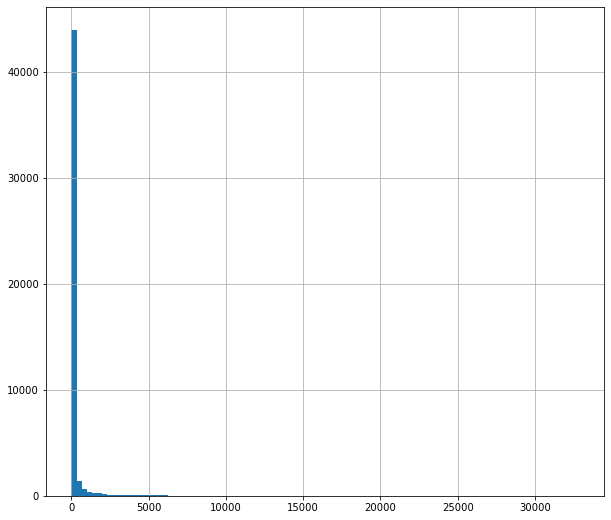

In [25]:
#plot graph of num of 
plt.figure(figsize=(10,9))

new_record['Count of total ratings'].hist(bins = 100)

<AxesSubplot:>

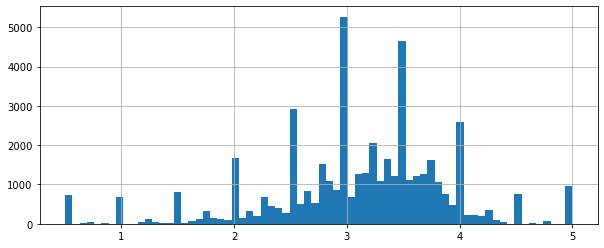

In [26]:
#plot graph of ratings column
plt.figure(figsize =(10,4))

new_record['Average_ratings'].hist(bins = 70)

<Figure size 576x432 with 0 Axes>

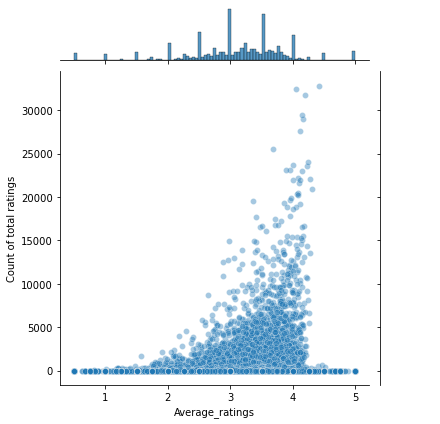

In [27]:
plt.figure(figsize=(8,6))
sns.jointplot(x='Average_ratings',  y='Count of total ratings',data=new_record,alpha=0.4)

**Most common Genres**

In [6]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(df_movies[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movies_genres.head()

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


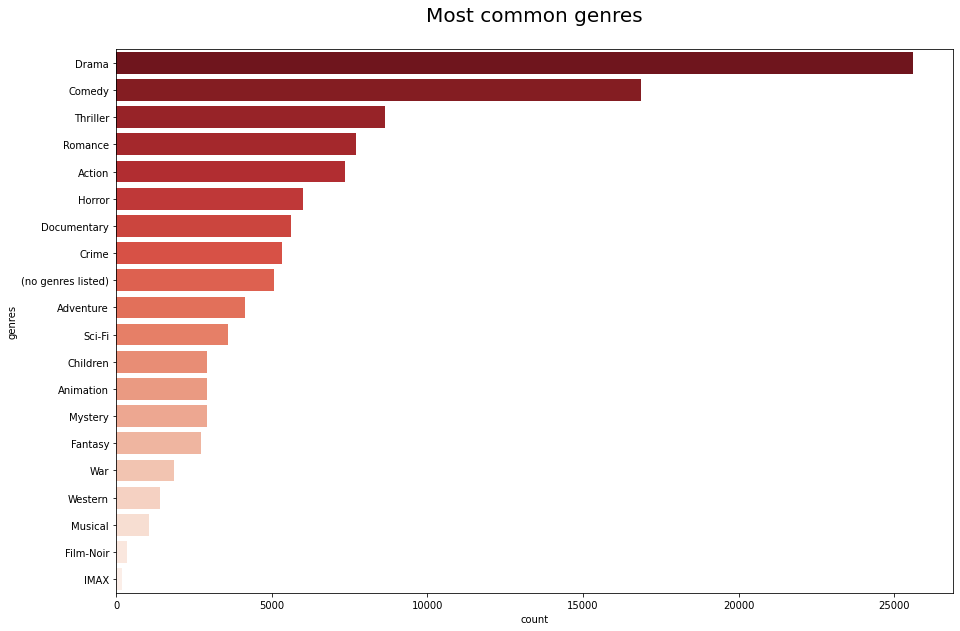

In [7]:
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()

## Data Prepartion

In [8]:
## Here you will sort your data out and process it accordingly

## Modelling phase

Here you can apply the models outline in the Intro to Recommender Notebook. You only need to apply one version 
be it Content based or Collabrative method



In [9]:
# Apply your modelling here

# Generate your outputs here

Prepare Submission File
We make submissions in CSV files. Your submissions usually have two columns: an ID column and a prediction column. The ID field comes from the test data (keeping whatever name the ID field had in that data, which for the data is the string 'Id'). The prediction column will use the name of the target field.

We will create a DataFrame with this data, and then use the dataframe's to_csv method to write our submission file. Explicitly include the argument index=False to prevent pandas from adding another column in our csv file.

In [10]:
# This is an example
## my_submission = pd.DataFrame({'id': test.Id, 'rating': test.ratings})
# you could use any filename. We choose submission here
## my_submission.to_csv('submission.csv', index=False)


### Make Submission
Hit the blue Publish button at the top of your notebook screen. It will take some time for your kernel to run. When it has finished your navigation bar at the top of the screen will have a tab for Output. This only shows up if you have written an output file (like we did in the Prepare Submission File step).

Example below of how the output would look once published

In [11]:
# initialize list of lists
data = [['tom', 10], ['nick', 15], ['juli', 14]]
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ['Name', 'Age'])
  
# print dataframe.
df

,Name,Age
0,tom,10
1,nick,15
2,juli,14


In [12]:
df.to_csv('my_test_output.csv', index = False)